# Lyft Decision Science Interview Homework
## Candidate: Tamirlan Seidakhmetov
## Date: 02/16/2018 - 02/18-2018

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib notebook

# Read Data and Explore

In [2]:
treatment_df = pd.read_csv('input/treatment_assignments.csv', dtype={'pseudo_id': object})
treatment_df.shape

(137697, 2)

In [3]:
outcome_df = pd.read_csv('input/outcomes_data.csv', dtype={'pseudo_id': object})
outcome_df.shape

(137622, 5)

In [4]:
treatment_df.head()

pseudo_id        variant
0    106009  GIVE10X5GET20
1    104584  GIVE10X5GET10
2    134900  GIVE5X10GET10
3     90719  GIVE10X5GET10
4     75090  GIVE5X10GET10

In [5]:
outcome_df.head()

pseudo_id  invite_attempts  invites_sent  coupon_applications  activation
0     98284                0             0                    0           0
1     58303                0             0                    0           0
2    114548                0             0                    0           0
3     75683                0             0                    0           0
4      7079                1             0                    0           0

### Distribution of promo variants

In [6]:
distr = treatment_df.variant.value_counts(normalize=True)
distr

GIVE10X5GET10    0.252729
GIVE5X10GET20    0.251102
GIVE10X5GET20    0.248705
GIVE5X10GET10    0.247464
Name: variant, dtype: float64

<IPython.core.display.Javascript object>


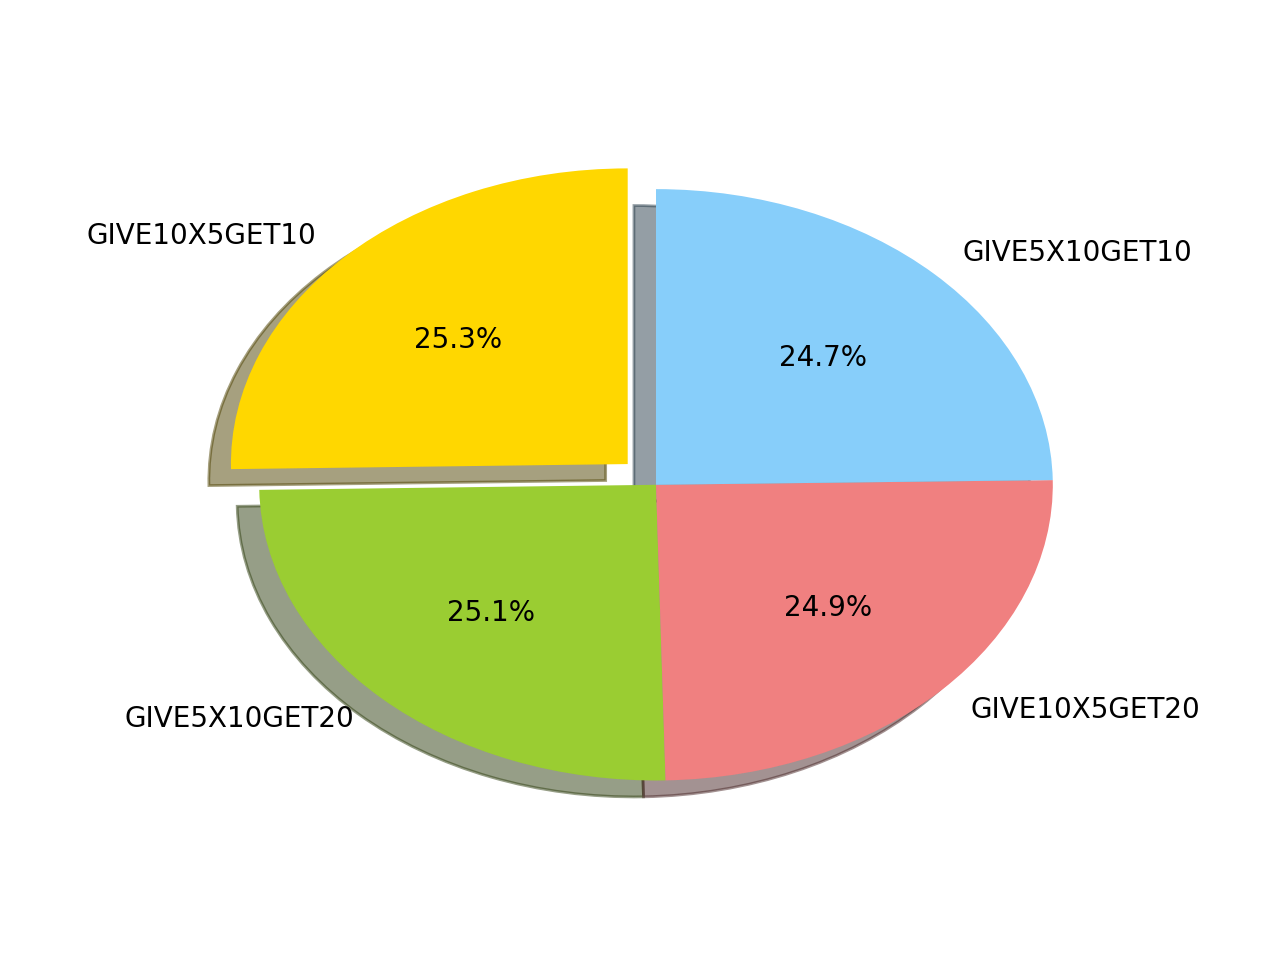

In [7]:
plt.figure()
explode = (0.1, 0, 0, 0)  # explode 1st slice
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
plt.pie(x=distr, explode=explode, labels=distr.index, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.savefig('output/img1_pie_chart.png');

### Outcome categories analysis

In [8]:
print('Cases where invite_attempts is less than invites_sent:', sum(outcome_df['invite_attempts'] < outcome_df['invites_sent']))

Cases where invite_attempts is less than invites_sent: 2168


In [9]:
print('Cases where invite_attempts is zero, but coupon_applications is greater than both invite_attempts and invites_sent:', sum((outcome_df['coupon_applications'] > outcome_df['invites_sent']) & (outcome_df['invite_attempts'] == 0)))
print('Total number of pseudo IDs that caused at least one "activation":', sum(outcome_df['activation'] > 0))

Cases where invite_attempts is zero, but coupon_applications is greater than both invite_attempts and invites_sent: 761
Total number of pseudo IDs that caused at least one "activation": 3932


In [10]:
print('Cases where coupon_applications is less than activations:', sum(outcome_df['coupon_applications'] < outcome_df['activation']))

Cases where coupon_applications is less than activations: 0


# Data Manipulation and Cleaning

### Pseudo ID duplicate analysis

In [11]:
# Number of users with single and double treatment
treatment_df.pseudo_id.value_counts().value_counts()

1    137547
2        75
Name: pseudo_id, dtype: int64

In [12]:
# Number of users with single and double outcome (no double outcome)
outcome_df.pseudo_id.value_counts().value_counts()

1    137622
Name: pseudo_id, dtype: int64

In [13]:
# Number of double treatment users with two identical promos
treatment_df.duplicated().sum()

16

In [14]:
dupl = treatment_df.pseudo_id.value_counts().reset_index()
dupl.columns = ['pseudo_id', 'count']
dupl = dupl[dupl['count'] == 2]
dupl.shape

(75, 2)

In [15]:
# Drop duplicates
print(treatment_df.shape)
treatment_df.drop_duplicates(subset='pseudo_id', keep=False, inplace=True)
treatment_df.shape

(137697, 2)


(137547, 2)

In [16]:
#check for duplicates
treatment_df.duplicated(subset='pseudo_id').sum()

0

### Merge Treatment Data with Outcomes Data

In [17]:
# Left join, since we do not want the "duplicated IDs" from outcome dataset that were dropped in treatment dataset
promo_df = pd.merge(treatment_df, outcome_df, on='pseudo_id', how='left')
promo_df.shape

(137547, 6)

In [18]:
promo_df.head()

pseudo_id        variant  invite_attempts  invites_sent  \
0    106009  GIVE10X5GET20                0             0   
1    104584  GIVE10X5GET10                0             0   
2    134900  GIVE5X10GET10                0             0   
3     90719  GIVE10X5GET10                0             0   
4     75090  GIVE5X10GET10                0             0   

   coupon_applications  activation  
0                    0           0  
1                    0           0  
2                    0           0  
3                    0           0  
4                    0           0

# Summary by Promo Variant

In [19]:
# Since we are interested in normalized values by the number of users in each treatment variant, therefore we apply
# mean statistics
var_grouping = promo_df.groupby('variant').mean()

In [20]:
# convert fractions to percents
for c in var_grouping.columns:
    var_grouping[c] = round(var_grouping[c]*100, 2)

In [21]:
# Take the min activation variant as a baseline and identify the fraction rise of other methods
var_grouping['activation_rise'] = var_grouping['activation'] / var_grouping['activation'].min()

In [22]:
var_grouping.sort_values('activation', ascending=False, inplace=True)
var_grouping

invite_attempts  invites_sent  coupon_applications  activation  \
variant                                                                         
GIVE5X10GET20            27.65         26.59                 5.07        3.48   
GIVE5X10GET10            26.18         26.49                 4.93        3.36   
GIVE10X5GET20            27.85         23.92                 5.14        3.18   
GIVE10X5GET10            26.31         25.03                 4.67        2.76   

               activation_rise  
variant                         
GIVE5X10GET20         1.260870  
GIVE5X10GET10         1.217391  
GIVE10X5GET20         1.152174  
GIVE10X5GET10         1.000000

In [23]:
# The standard deviations table shows that it is difficult to choose one best candidate
promo_df.groupby('variant').std()

invite_attempts  invites_sent  coupon_applications  activation
variant                                                                      
GIVE10X5GET10         1.241449      3.224761             0.235914    0.175429
GIVE10X5GET20         1.070474      2.091117             0.356361    0.237669
GIVE5X10GET10         1.075564      4.637153             0.384926    0.269329
GIVE5X10GET20         1.184440      3.324215             0.284897    0.223471

<IPython.core.display.Javascript object>


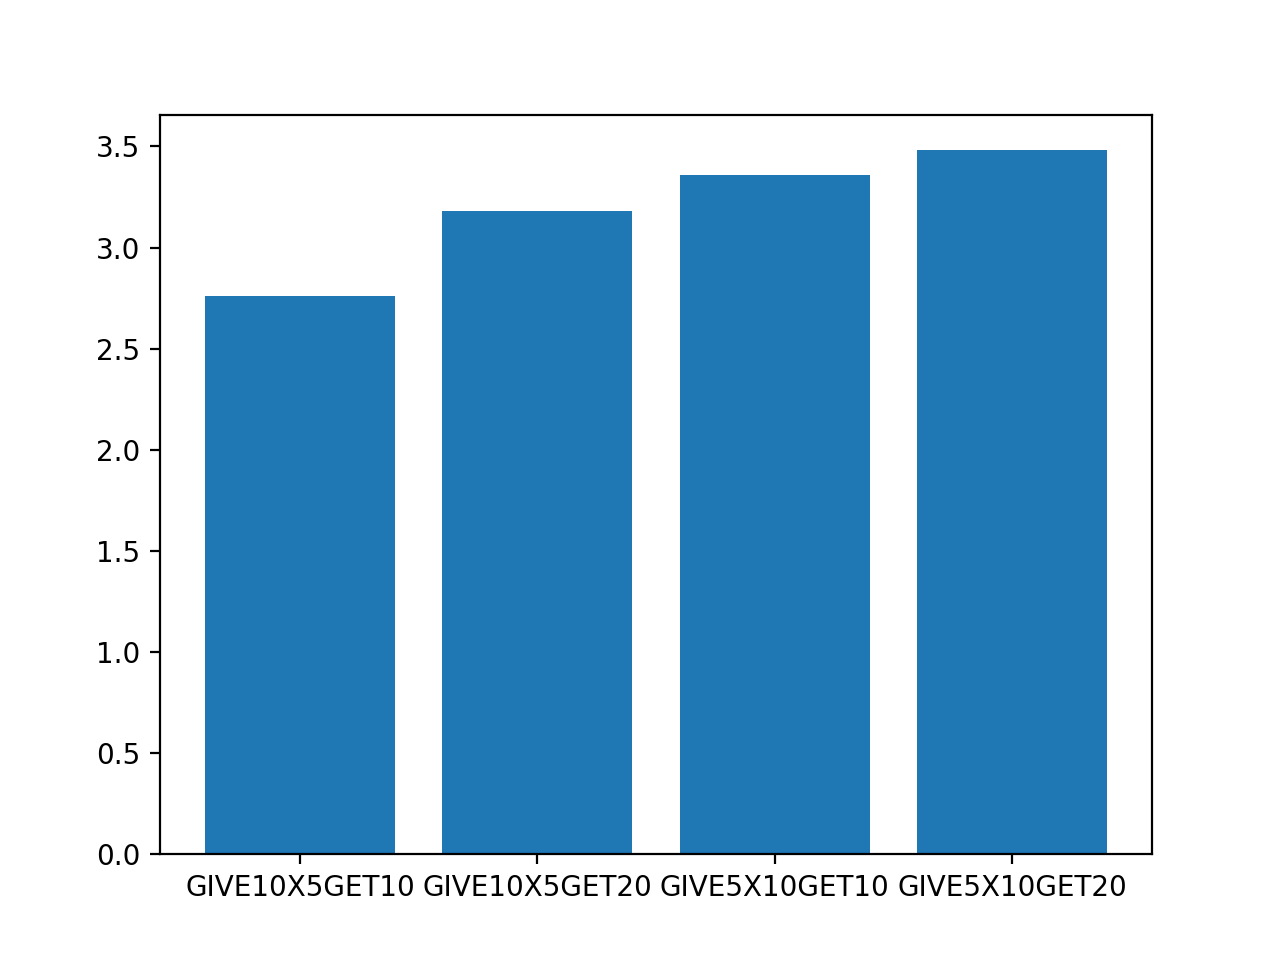

<Container object of 4 artists>

In [24]:
plt.figure()
plt.bar(var_grouping.index, var_grouping['activation'])

# Test data for normality

# Test assumptions

In [25]:
from scipy.stats.mstats import normaltest
from scipy.stats import shapiro

In [26]:
normaltest(promo_df['activation'])

NormaltestResult(statistic=380052.71677040251, pvalue=0.0)

In [27]:
shapiro(promo_df['activation'])

/Users/tamirlan/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:1326: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.11289852857589722, 0.0)

# Kruskal-Wallis one-way analysis of variance

In [28]:
from scipy.stats.mstats import kruskalwallis

In [29]:
var_grouping

invite_attempts  invites_sent  coupon_applications  activation  \
variant                                                                         
GIVE5X10GET20            27.65         26.59                 5.07        3.48   
GIVE5X10GET10            26.18         26.49                 4.93        3.36   
GIVE10X5GET20            27.85         23.92                 5.14        3.18   
GIVE10X5GET10            26.31         25.03                 4.67        2.76   

               activation_rise  
variant                         
GIVE5X10GET20         1.260870  
GIVE5X10GET10         1.217391  
GIVE10X5GET20         1.152174  
GIVE10X5GET10         1.000000

In [30]:
variants = var_grouping.sort_values('activation', ascending=False).index
variants

Index(['GIVE5X10GET20', 'GIVE5X10GET10', 'GIVE10X5GET20', 'GIVE10X5GET10'], dtype='object', name='variant')

In [31]:
activation_per_variant = {}
for v in variants:
    activation = promo_df[promo_df['variant'] == v]['activation'].tolist()
    activation_per_variant[v] = activation

In [32]:
print("Kruskal Wallis H-test test:")

H, pval = kruskalwallis(activation_per_variant[variants[0]],
                       activation_per_variant[variants[1]],
                       activation_per_variant[variants[2]],
                       activation_per_variant[variants[3]])

print("H-statistic:", H)
print("P-Value:", pval)

if pval < 0.05:
    print("Reject NULL hypothesis - Significant differences exist between groups.")
if pval > 0.05:
    print("Accept NULL hypothesis - No significant difference between groups.")

Kruskal Wallis H-test test:
H-statistic: 15.208964035
P-Value: 0.00164650817959
Reject NULL hypothesis - Significant differences exist between groups.


# Mann–Whitney U test

In [33]:
from scipy.stats import mannwhitneyu

In [34]:
0.05/6

0.008333333333333333

In [35]:
rules = []
for i, vi in enumerate(variants):
    for j, vj in enumerate(variants[i+1:]):
        print(vi, vj)
        stats, p_val = mannwhitneyu(activation_per_variant[vi], activation_per_variant[vj])
        if p_val < 0.05/6:
            print(p_val, '- reject the null hypothesis.', vi, 'is better than', vj)
            rules.append(vi+' > '+vj)
        else:
            print(p_val, '- do not reject the null hypothesis.', vi, 'and', vj, 'has unknown relationship')

GIVE5X10GET20 GIVE5X10GET10
0.131253246927 - do not reject the null hypothesis. GIVE5X10GET20 and GIVE5X10GET10 has unknown relationship
GIVE5X10GET20 GIVE10X5GET20
0.0997668426457 - do not reject the null hypothesis. GIVE5X10GET20 and GIVE10X5GET20 has unknown relationship
GIVE5X10GET20 GIVE10X5GET10
6.98352580362e-05 - reject the null hypothesis. GIVE5X10GET20 is better than GIVE10X5GET10
GIVE5X10GET10 GIVE10X5GET20
0.4365608683 - do not reject the null hypothesis. GIVE5X10GET10 and GIVE10X5GET20 has unknown relationship
GIVE5X10GET10 GIVE10X5GET10
0.00374184609312 - reject the null hypothesis. GIVE5X10GET10 is better than GIVE10X5GET10
GIVE10X5GET20 GIVE10X5GET10
0.0058865323296 - reject the null hypothesis. GIVE10X5GET20 is better than GIVE10X5GET10


In [36]:
rules

['GIVE5X10GET20 > GIVE10X5GET10',
 'GIVE5X10GET10 > GIVE10X5GET10',
 'GIVE10X5GET20 > GIVE10X5GET10']

# Look at Parts of Promotions Separately

In [37]:
# Create features for different give and get promos
promo_df['give_promo'] = promo_df['variant'].apply(lambda x: x[:8])
promo_df['get_promo'] = promo_df['variant'].apply(lambda x: x[8:])

In [38]:
promo_df.head()

pseudo_id        variant  invite_attempts  invites_sent  \
0    106009  GIVE10X5GET20                0             0   
1    104584  GIVE10X5GET10                0             0   
2    134900  GIVE5X10GET10                0             0   
3     90719  GIVE10X5GET10                0             0   
4     75090  GIVE5X10GET10                0             0   

   coupon_applications  activation give_promo get_promo  
0                    0           0   GIVE10X5     GET20  
1                    0           0   GIVE10X5     GET10  
2                    0           0   GIVE5X10     GET10  
3                    0           0   GIVE10X5     GET10  
4                    0           0   GIVE5X10     GET10

### GET10 vs GET20

In [39]:
# Since we are interested in normalized values by the number of users in each treatment variant, therefore we apply
# mean statistics
get_grouping = promo_df.groupby('get_promo').mean()

In [40]:
# Take the min activation get_promo as a baseline and identify the fraction rise of other methods
get_grouping['activation_rise'] = get_grouping['activation'] / get_grouping['activation'].min()

In [41]:
# convert fractions to percents
for c in get_grouping.columns:
    get_grouping[c] = round(get_grouping[c]*100, 2)

In [42]:
get_grouping

invite_attempts  invites_sent  coupon_applications  activation  \
get_promo                                                                   
GET10                26.25         25.75                 4.80        3.06   
GET20                27.75         25.27                 5.11        3.33   

           activation_rise  
get_promo                   
GET10               100.00  
GET20               108.84

In [43]:
print("Kruskal Wallis H-test test:")

candidate1 = 'GET20'
candidate2 = 'GET10'
list1 = promo_df[promo_df['get_promo'] == candidate1]['activation'].tolist()
list2 = promo_df[promo_df['get_promo'] == candidate2]['activation'].tolist()

H, pval = kruskalwallis(list1, list2)

print("H-statistic:", H)
print("P-Value:", pval)

if pval < 0.05:
    print("Reject NULL hypothesis - Significant differences exist between groups.")
if pval > 0.05:
    print("Accept NULL hypothesis - No significant difference between groups.")

Kruskal Wallis H-test test:
H-statistic: 6.62641891361
P-Value: 0.0100477068307
Reject NULL hypothesis - Significant differences exist between groups.


In [44]:
stats, p_val = mannwhitneyu(list1, list2)
if p_val < 0.05:
    print(p_val, '- reject the null hypothesis.', candidate1, 'is better than', candidate2)
    rules.append(candidate1+' > '+candidate2)
else:
    print(p_val, '- do not reject the null hypothesis.', candidate1, 'and', candidate2, 'has unknown relationship')

0.00502385683285 - reject the null hypothesis. GET20 is better than GET10


In [45]:
rules

['GIVE5X10GET20 > GIVE10X5GET10',
 'GIVE5X10GET10 > GIVE10X5GET10',
 'GIVE10X5GET20 > GIVE10X5GET10',
 'GET20 > GET10']

### GIVE5X10 vs GIVE10X5

In [46]:
# Since we are interested in normalized values by the number of users in each treatment variant, therefore we apply
# mean statistics
give_grouping = promo_df.groupby('give_promo').mean()

In [47]:
# Take the min activation give_promo as a baseline and identify the fraction rise of other methods
give_grouping['activation_rise'] = give_grouping['activation'] / give_grouping['activation'].min()

In [48]:
# convert fractions to percents
for c in give_grouping.columns:
    give_grouping[c] = round(give_grouping[c]*100, 2)

In [49]:
give_grouping

invite_attempts  invites_sent  coupon_applications  activation  \
give_promo                                                                   
GIVE10X5              27.07         24.48                  4.9        2.97   
GIVE5X10              26.92         26.54                  5.0        3.42   

            activation_rise  
give_promo                   
GIVE10X5             100.00  
GIVE5X10             115.37

In [50]:
print("Kruskal Wallis H-test test:")

candidate1 = 'GIVE5X10'
candidate2 = 'GIVE10X5'
list1 = promo_df[promo_df['give_promo'] == candidate1]['activation'].tolist()
list2 = promo_df[promo_df['give_promo'] == candidate2]['activation'].tolist()

H, pval = kruskalwallis(list1, list2)

print("H-statistic:", H)
print("P-Value:", pval)

if pval < 0.05:
    print("Reject NULL hypothesis - Significant differences exist between groups.")
if pval > 0.05:
    print("Accept NULL hypothesis - No significant difference between groups.")

Kruskal Wallis H-test test:
H-statistic: 7.82850611943
P-Value: 0.00514285876109
Reject NULL hypothesis - Significant differences exist between groups.


In [51]:
stats, p_val = mannwhitneyu(list1, list2)
if p_val < 0.05:
    print(p_val, '- reject the null hypothesis.', candidate1, 'is better than', candidate2)
    rules.append(candidate1+' > '+candidate2)
else:
    print(p_val, '- do not reject the null hypothesis.', candidate1, 'and', candidate2, 'has unknown relationship')

0.00257143125306 - reject the null hypothesis. GIVE5X10 is better than GIVE10X5


In [52]:
rules

['GIVE5X10GET20 > GIVE10X5GET10',
 'GIVE5X10GET10 > GIVE10X5GET10',
 'GIVE10X5GET20 > GIVE10X5GET10',
 'GET20 > GET10',
 'GIVE5X10 > GIVE10X5']

# Additional experiments with ANOVA/Tukey (even if data is not normal, since sample size is large). Might not be very reliable

### One-Way ANOVA

In [53]:
from scipy import stats

In [54]:
# f, p = stats.f_oneway(data[data['Archer'] == 'Pat'].Score,
#                       data[data['Archer'] == 'Jack'].Score,
#                       data[data['Archer'] == 'Alex'].Score)
 
f, p = stats.f_oneway(promo_df[promo_df['variant'] == 'GIVE5X10GET20']['activation'],
                     promo_df[promo_df['variant'] == 'GIVE5X10GET10']['activation'],
                     promo_df[promo_df['variant'] == 'GIVE10X5GET20']['activation'],
                     promo_df[promo_df['variant'] == 'GIVE10X5GET10']['activation'])
print ('F value:', f)
print ('P value:', p)
print ('As 0.002≤0.05 we reject the null hypothesis and we conclude that at least one of the means is different from at least one other population mean (i.e. not all promo variants perform equally).')

F value: 6.63266072313
P value: 0.000178325504556
As 0.002≤0.05 we reject the null hypothesis and we conclude that at least one of the means is different from at least one other population mean (i.e. not all promo variants perform equally).


### Tukey's range test

In [55]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

In [56]:
promo_df.head()

pseudo_id        variant  invite_attempts  invites_sent  \
0    106009  GIVE10X5GET20                0             0   
1    104584  GIVE10X5GET10                0             0   
2    134900  GIVE5X10GET10                0             0   
3     90719  GIVE10X5GET10                0             0   
4     75090  GIVE5X10GET10                0             0   

   coupon_applications  activation give_promo get_promo  
0                    0           0   GIVE10X5     GET20  
1                    0           0   GIVE10X5     GET10  
2                    0           0   GIVE5X10     GET10  
3                    0           0   GIVE10X5     GET10  
4                    0           0   GIVE5X10     GET10

In [57]:
mc = MultiComparison(promo_df['activation'], promo_df['variant'])
result = mc.tukeyhsd(alpha=0.05)
 
print(result)
print(mc.groupsunique)

    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
GIVE10X5GET10 GIVE10X5GET20  0.0042  -0.0003 0.0087 False 
GIVE10X5GET10 GIVE5X10GET10  0.0061   0.0016 0.0106  True 
GIVE10X5GET10 GIVE5X10GET20  0.0072   0.0027 0.0117  True 
GIVE10X5GET20 GIVE5X10GET10  0.0019  -0.0026 0.0064 False 
GIVE10X5GET20 GIVE5X10GET20  0.003   -0.0015 0.0075 False 
GIVE5X10GET10 GIVE5X10GET20  0.0011  -0.0034 0.0056 False 
----------------------------------------------------------
['GIVE10X5GET10' 'GIVE10X5GET20' 'GIVE5X10GET10' 'GIVE5X10GET20']


In [58]:
mc = MultiComparison(promo_df['invite_attempts'], promo_df['get_promo'])
result = mc.tukeyhsd(alpha=0.05)
 
print(result)
print(mc.groupsunique)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower upper  reject
------------------------------------------
GET10  GET20   0.0151  0.003 0.0272  True 
------------------------------------------
['GET10' 'GET20']


In [59]:
mc = MultiComparison(promo_df['activation'], promo_df['give_promo'])
result = mc.tukeyhsd(alpha=0.05)
 
print(result)
print(mc.groupsunique)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff lower  upper reject
----------------------------------------------
GIVE10X5 GIVE5X10  0.0046  0.0021 0.007  True 
----------------------------------------------
['GIVE10X5' 'GIVE5X10']


## Two-Way ANOVA

In [60]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [61]:
formula = 'activation ~ C(get_promo) + C(give_promo) + C(get_promo):C(give_promo)'
model = ols(formula, promo_df).fit()
aov_table = anova_lm(model, typ=2)
aov_table

sum_sq        df          F    PR(>F)
C(get_promo)                   0.244672       1.0   4.676753  0.030575
C(give_promo)                  0.707693       1.0  13.527118  0.000235
C(get_promo):C(give_promo)     0.082154       1.0   1.570322  0.210162
Residual                    7195.782331  137543.0        NaN       NaN

In [62]:
formula = 'activation ~ C(get_promo) + C(give_promo)'
model = ols(formula, promo_df).fit()
aov_table = anova_lm(model, typ=2)
aov_table

sum_sq        df          F    PR(>F)
C(get_promo)      0.244672       1.0   4.676734  0.030576
C(give_promo)     0.707693       1.0  13.527062  0.000235
Residual       7195.864485  137544.0        NaN       NaN